# MME Plotting

### Description:
We will be looking at the four largest ensembles, calculating their gradient trends and then seeing where observations lie within those ranges. Additionally, we will be quantifying where the observations lie within those ranges (i.e., ascertaining whether the models are struggling more to encompass these trends with time

### Structure:
#### This code:
Second part of the code will read in observational data  
Third part of the code will read back in the model trend data and compare it with observations, including plotting  
Fourth part will calcluate MME mean for the models and also plot this  
Fifth part will calculate the universal 95% range of the models and plot observations relative to this  
Sixth part of the code calculates two metrics that may be predictive of model ability to capture observations

#### Other codes:
Initial part of the code will be for selecting and running the models; output in the form of gradients and trends will be saved to a directory  

### Notes:  

In [174]:
%reset -f

In [175]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
%reload_ext autoreload
%autoreload 2

In [190]:
# analysis functions
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import percentileofscore
from scipy.stats import linregress
from scipy.stats import pearsonr

# plotting functions
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# systems functions
import os
from collections import defaultdict
from datetime import date

# my own classes and functions
from GradTrendClasses import ModelInput, Trend, TrendPlotting, CalculateMMEGradient, CalculateObsGradient, Gradient, CalcIntervalDiff
from GradientProjectFunctions import RemoveClimatology, DictToDf, TrendsDictFromFiles, CalculateTrendPercentile, FlagInRange, ClassifyModels
from GradientProjectFunctions import CalculateModelRange, CalculateObsPercentile, CreateScenarioDictionary, ExtendPeriod, ConcatModels, ClassifyHistModelsLite, ScaleTrends

## Setting up directory and file names

#### Outputs

In [191]:
#_____Plots________
pathBase = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/'
plotsEnd = 'Plots_FullPeriod'

plotsDir = pathBase + plotsEnd

#### Inputs

In [192]:
#_____Hadley___________
# obsDir = '/home/hbyrne/Research/QMDA_2023'
obsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Inputs'
inputDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Inputs'

# inputting from a csv file
openDapDir = '/home/hbyrne/Research/Gradient_project/OpenDap_inputs'

#____Stats______
statsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Model_Statistics'

#______Trends and Gradients________
pathBase = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/'
#trendsDirEnd = 'Trends_' + str(date.today())
trendsDirEnd = 'Trends_FullPeriod'
#gradientsDirEnd = 'Gradients_' + str(date.today())
gradientsDirEnd = 'Gradients_FullPeriod'

trendsDir = pathBase + trendsDirEnd
gradientsDir = pathBase + gradientsDirEnd

## 2) Reading in the observational data

In [193]:
# fileName = 'HadISST_sst 2.nc'
fileName = 'HadISST_sst (1).nc'
os.chdir(obsDir)

In [194]:
# running the classes on it
modelInput = ModelInput(fileName)

# have to roll the coordinates for Hadley
modelInput = modelInput.ds.assign_coords(lon = ((360 + (modelInput.ds.lon % 360)) % 360))
modelInput = modelInput.roll(lon = int(len(modelInput['lon']) / 2), roll_coords = True)

# remove climatology
modelInput = RemoveClimatology(modelInput)

# calculate the gradient
gradient = CalculateObsGradient(modelInput, 'HadleyISST')

# calculate the trend
trendsHad = Trend(gradient, 20, 1870, 2023).trends
trendsHadDf = Trend(gradient, 20, 1870, 2023).trendsDf

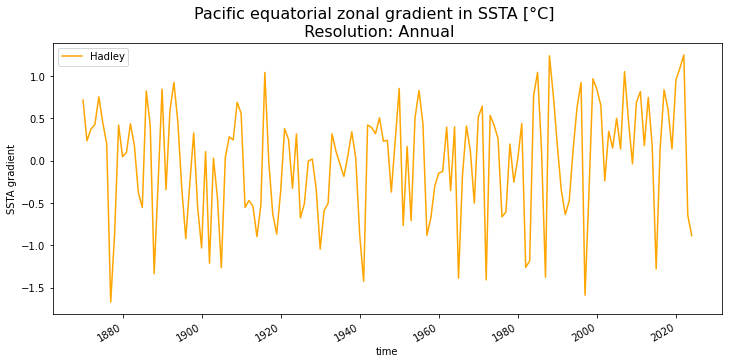

In [195]:
# HADLEY
gradientHadYear = gradient.gradient.resample(time = 'YS').mean()
timeHad = np.arange(len(gradientHadYear))

slope, intercept = np.polyfit(timeHad, gradientHadYear, 1)

slopeHad = intercept + slope*timeHad

# MODEL
model = 'MIROC6'
os.chdir(gradientsDir)
gradientModelMean = CalculateMMEGradient(gradientsDir, model)
gradientModelMeanYear = gradientModelMean.gradient.resample(time = 'YS').mean().sel(time = slice(gradientHadYear.time[0], gradientHadYear.time[-1]))

# calcluating the linear fit of the MME
timeModel = np.arange(len(gradientModelMeanYear))
slope, intercept = np.polyfit(timeModel, gradientModelMeanYear, 1)

# now plotting this
# calculating the new lines
slopeModel = intercept + slope*timeModel

# PLOTTING
fig, ax = plt.subplots(figsize = (12,5))
fig.suptitle('Pacific equatorial zonal gradient in SSTA [°C] \n Resolution: Annual', fontsize = 16)

gradientHadYear.plot(color = 'orange', label = 'Hadley')
#plt.plot(gradientHadYear.time, slopeHad, color = 'orange', label = 'Hadley')
#gradientModelMeanYear.plot(color = 'darkgray')
#plt.plot(gradientModelMeanYear.time, slopeModel, color = 'purple', label = f'{model}')
ax.set_ylabel('SSTA gradient')

plt.legend()
plt.show()





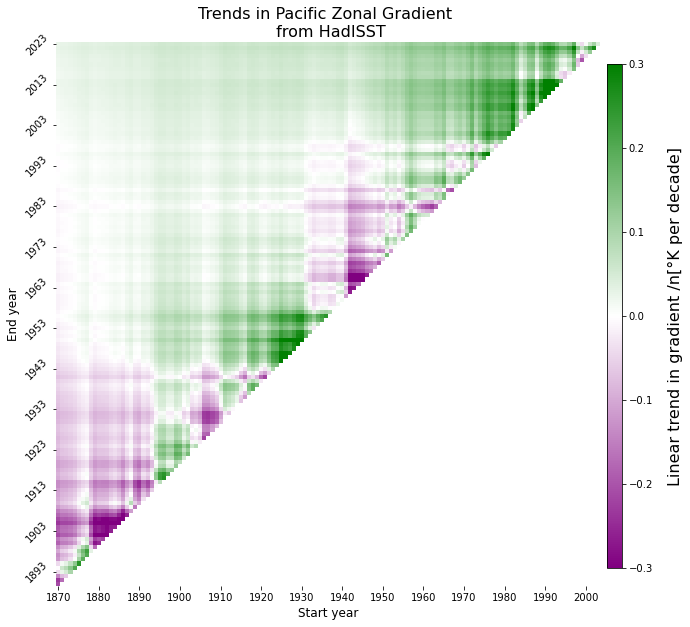

In [196]:
# the Had data has end dates that start at 1870 and start dates up to 2022

# calculate the vmin and vmax
vmin = trendsHadDf.min().min()
vmax = trendsHadDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
vmin = -0.3
vmax = -vmin
    
# setting the colorbar
colors = [(0,'purple'), (0.50,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

# plotting the figure
fig = plt.figure(figsize = (10,10))
axesList = []

ax = fig.add_subplot(111)
ax.set_aspect('equal')
trendPlotter = TrendPlotting(trendsHadDf, 'Trends in Pacific Zonal Gradient \n from HadISST', vmin, vmax, cmap, norm)
plot = trendPlotter.PlotTrends(ax)  
axesList.append(ax)

cbarAx = fig.add_axes([0.9, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('Linear trend in gradient /n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 16)

# saving the figure
# making and changing the directory
if os.path.isdir(plotsDir):
    os.chdir(plotsDir)
else:
    os.mkdir(plotsDir)
    os.chdir(plotsDir)

fileName = 'Hadley.png'
plt.savefig(fileName)

plt.show()

## 3) Read back in the trend data and calculate the 95% interval

Adding in functionality here, per Jason and Richard:  
Percentile where the observation lies  
Variance for each (maybe difference between 95% and 5%)

In [197]:
# read in the model summary for ordering

os.chdir(statsDir)
modelSummary = pd.read_csv('ModelSummaries.csv', index_col=0)

# now order them according to one of the metrics and pull out the indices
models = list(modelSummary.sort_values(by = 'CorrHad', ascending = False).index)

In [198]:
print(models)

['MPI-ESM1-2-LR', 'CNRM-CM6-1', 'IPSL-CM6A-LR', 'ACCESS-ESM1-5', 'CanESM5', 'GISS-E2-1-G', 'MIROC6', 'MIROC-ES2L']


MPI-ESM1-2-LR done and dusted
CNRM-CM6-1 done and dusted
IPSL-CM6A-LR done and dusted
ACCESS-ESM1-5 done and dusted
CanESM5 done and dusted
GISS-E2-1-G done and dusted
MIROC6 done and dusted
MIROC-ES2L done and dusted


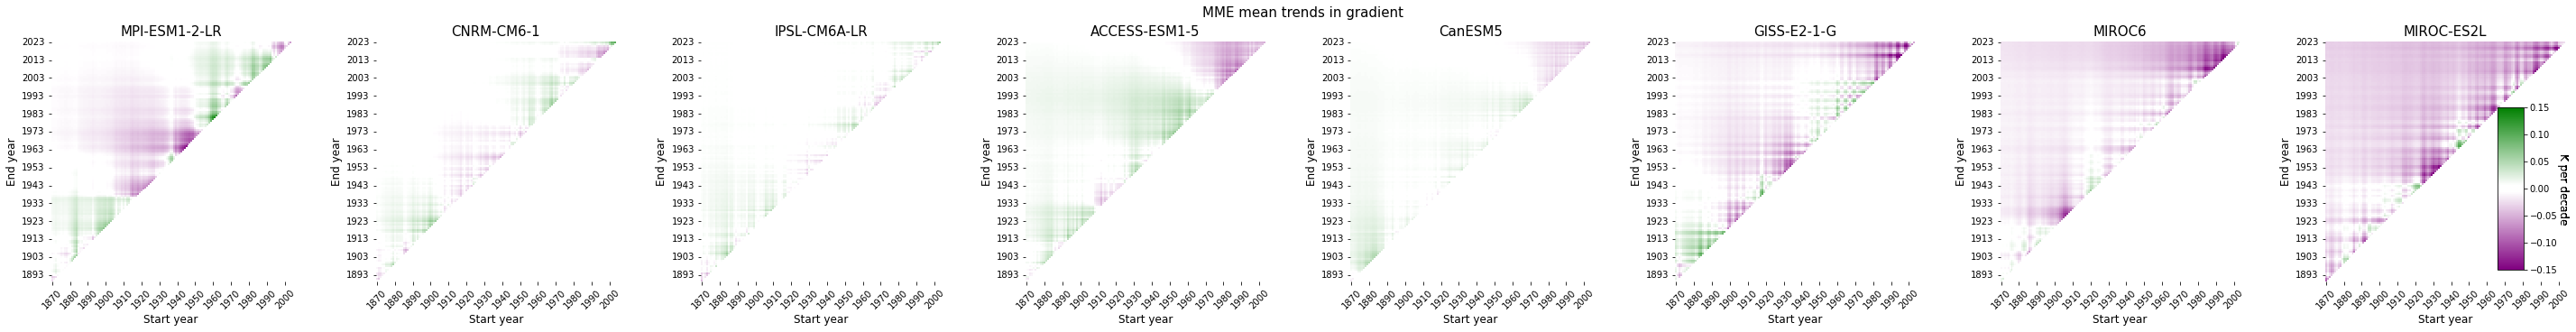

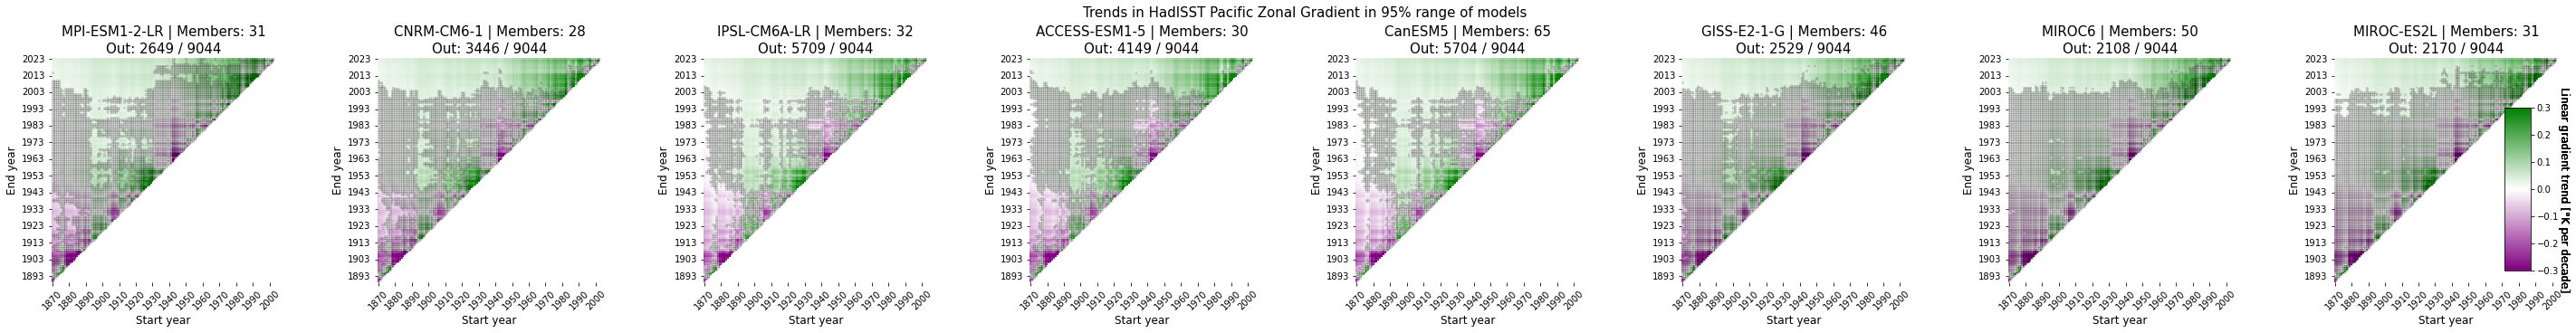

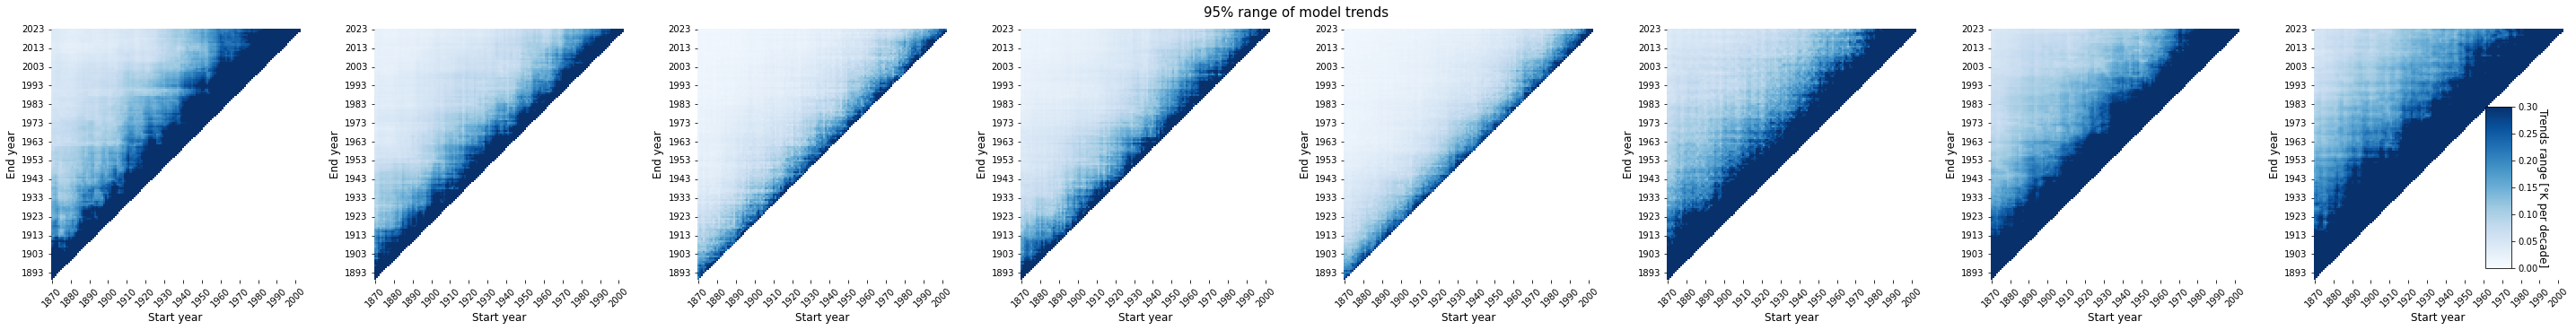

In [199]:
os.chdir(trendsDir)

# model names so it can loop through and just select those models
#models = ['CanESM5', 'MIROC6', 'GISS-E2-1-G', 'MPI-ESM1-2-LR', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'ACCESS-ESM1-5', 'CNRM-CM6-1']

# establishing some dictionaries to hold universal values (for now just universal 95% and 5% for all models)
dictLowerUni = defaultdict(list)
dictUpperUni = defaultdict(list)
trendsUni = defaultdict(list)
dictRanges = {}
dictPercentIn = {}
dictMembersNum = {}
dictObsInRangeAll = {}

# ___Plotting Figures____

# __Universal attributes___
nFigures = len(models)
nCols = nFigures

if nFigures % nCols == 0:
    nRows = int(nFigures/nCols)
else:
    nRows = int(np.floor(nFigures/nCols) + 1)

subplotSize = (5, 5)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]


# ___Obs in Range____

# create the axes list
axesList = []

# create the figure
fig1 = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig1.suptitle('MME mean trends in gradient', fontsize = 15)

# ___Obs percentile___
fig2 = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig2.suptitle('Trends in HadISST Pacific Zonal Gradient in 95% range of models', fontsize = 15)

# __Model range___
fig3 = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig3.suptitle('95% range of model trends', fontsize = 15)


for i, model in enumerate(models):
    
    # ----------------------
    # MME Mean
    # ----------------------
    
    # open each file for that model and add it to the previous one
    os.chdir(trendsDir)
    trendsFiles = os.listdir(trendsDir)
    trendsDfs = [pd.read_csv(trendsFile, index_col = 0) for trendsFile in trendsFiles if '.csv' in trendsFile and model in trendsFile]
    trendsDfMean = sum(trendsDfs) / len(trendsDfs)
    
    # ----------------------
    # Obs in range
    # ----------------------
    
    # create a dictionary with all of the trends from this directory
    trendsDict = TrendsDictFromFiles(trendsDir, model)
    trendsUni[model].append(trendsDict)
    
    # count the number of models
    memberCount = len(trendsDict[1870,2022])
    dictMembersNum[model] = memberCount
    
    # create dictionaries with lower and upper percentiles from the distribution of trends
    dictLower, dictUpper = CalculateTrendPercentile(trendsDict, 2.5, 97.5)
    
    # saving these values to the universal dictionaries (entire dictionaries where each main key is the model name)
    dictLowerUni[model] = dictLower
    dictUpperUni[model] = dictUpper

    # flagging everywhere that the values lie within the range of the models
    dictObsInRange = FlagInRange(dictLower, dictUpper, trendsHad)
    
    # counting the number of grid points inside
    countOut = list(dictObsInRange.values()).count(0)
    countTotal = list(dictObsInRange.values()).count(1)+list(dictObsInRange.values()).count(0)
    dictPercentIn[model] = (countTotal - countOut)/countTotal

    # creating a dataframe for the ObsInRange
    dfObsInRange = DictToDf(dictObsInRange)

    # removing the bottom 20 rows so that this stippling df has the same dimensions as the observations
    keepRows = [row for row in dfObsInRange.index if row >= 1890]
    dfObsInRange = dfObsInRange.loc[keepRows, :]
    dictObsInRangeAll[model] = dfObsInRange
    
    # ----------------------
    # Model Range
    # ----------------------
    
    dfRange = CalculateModelRange(dictLower, dictUpper)
    dictRanges[model] = dfRange
    
    # plotting
    
    #___MME MEAN___
    
    # calculate the vmin and vmax
    vmin = -0.15 # note that these were set manually after this had run once and the vmin and max had been determined
    vmax = -vmin

    # setting the colorbar
    colors = [(0,'purple'), (0.48,'white'), (0.52,'white'), (1,'green')]
    cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

    ax = fig1.add_subplot(nRows, nCols, i+1)
    ax.set_title(f'{model}', fontsize = 15)
    ax.set_aspect('equal')
    plot = sns.heatmap(trendsDfMean, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    ax.tick_params(axis = 'x', rotation = 45)
    ax.tick_params(axis = 'y', rotation = 0)
    ax.set_ylabel('End year', fontsize = 12)
    ax.set_xlabel('Start year', fontsize = 12)
    axesList.append(ax)

    cbarAx = fig1.add_axes([0.96, 0.18, 0.01, 0.5])
    colorBar = fig1.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('K per decade', rotation = 270, labelpad = 12, fontsize = 12)
    
    
    #___OBS IN RANGE___

    # calculate the vmin and vmax
    vmin = trendsHadDf.min().min()
    vmax = trendsHadDf.max().max()

    # find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
    if (vmin < 0) & (vmax > 0):
        limit = max(abs(vmin), abs(vmax))
        vmin = -limit
        vmax = limit

    vmin = -0.3
    vmax = -vmin

    # setting the colorbar
    colors = [(0,'purple'), (0.50,'white'), (1,'green')]
    cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

    ax = fig2.add_subplot(nRows, nCols, i+1)
    ax.set_aspect('equal')
    ax.set_title(f'{model} | Members: {memberCount}\nOut: {countOut} / {countTotal}', fontsize = 15)
    plot = sns.heatmap(trendsHadDf, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, center = 0, cbar = False, norm = norm)
    ax.tick_params(axis = 'x', rotation = 45)
    ax.tick_params(axis = 'y', rotation = 0)
    ax.set_ylabel('End year', fontsize = 12)
    ax.set_xlabel('Start year', fontsize = 12)

    cbarAx = fig2.add_axes([0.96, 0.18, 0.01, 0.5])
    colorBar = fig2.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Linear gradient trend [°K per decade]', rotation = 270, labelpad = 12, fontsize = 12)

    # adding the stippling with a for loop
    for a, row in enumerate(dfObsInRange.values):
        for b, value in enumerate(row):
            if value == 1:
                plot.add_patch(plt.Rectangle((b, a), 1, 1, fill=True, color = 'black', edgecolor=None, alpha = 0.1))
    
    #___OBS RANGE___
    
    vmin = 0
    vmax = 0.3 # Note that these values were selected after running it once and looking at the max and min of the whole spread; have to be changed manually
    
    # setting the colorbar
    cmap = 'Blues'
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

    ax = fig3.add_subplot(nRows, nCols, i+1)
    ax.set_aspect('equal')    
    #ax.set_title(f'{model}', fontsize = 15)
    plot = sns.heatmap(dfRange, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    ax.tick_params(axis = 'x', rotation = 45)
    ax.tick_params(axis = 'y', rotation = 0)
    ax.set_ylabel('End year', fontsize = 12)
    ax.set_xlabel('Start year', fontsize = 12)

    cbarAx = fig3.add_axes([0.96, 0.18, 0.01, 0.5])
    colorBar = fig3.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Trends range [°K per decade]', rotation = 270, labelpad = 12, fontsize = 12)
    
    print(f'{model} done and dusted')

# saving the figures
# making and changing the directory
if os.path.isdir(plotsDir):
    os.chdir(plotsDir)
else:
    os.mkdir(plotsDir)
    os.chdir(plotsDir)

fileName = 'Model_summaries_ALL'

for i, fig in enumerate(plt.get_fignums()):
    plt.figure(fig)
    plt.savefig(f'{fileName}_{i}.png')

plt.show()

## 4) Calculating the mean

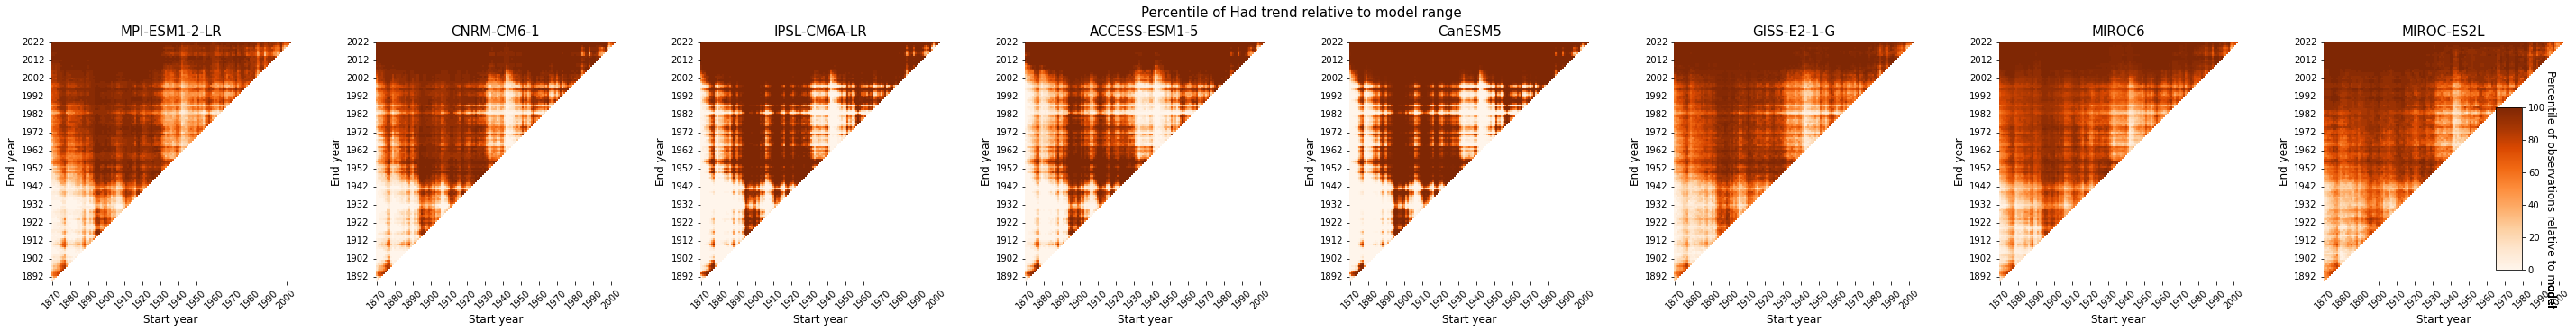

In [14]:
# gradientsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients_240311'

# doing this for each of the models

# creating a dictionary to hold the trends to get max and min for plotting
dictTrends = defaultdict(list)
dictDiff = {}

# __Universal attributes___
nFigures = len(models)
nCols = nFigures

if nFigures % nCols == 0:
    nRows = int(nFigures/nCols)
else:
    nRows = int(np.floor(nFigures/nCols) + 1)

subplotSize = (5, 5)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]


# ___Obs in Range____

# create the axes list
axesList = []

# create the figure
fig4 = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig4.suptitle('Percentile of Had trend relative to model range', fontsize = 15)

# running the loop through the models
for i, model in enumerate(models):
    
    # ----------------------
    # Obs percentile
    # ----------------------
    os.chdir(trendsDir)
    trendsDict = TrendsDictFromFiles(trendsDir, model)
    dfObsPercentile = CalculateObsPercentile(trendsDict, trendsHad)


    # -----------------
    # PLOTTING
    # -----------------
    
    #___OBS PERCENTILE___
    # set max and min though they will always be the same
    vmin = 0
    vmax = 100

    # setting the colorbar
    cmap = 'Oranges'
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

    ax = fig4.add_subplot(nRows, nCols, i+1)
    ax.set_aspect('equal')
    ax.set_title(f'{model}', fontsize = 15)
    plot = sns.heatmap(dfObsPercentile, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    ax.tick_params(axis = 'x', rotation = 45)
    ax.tick_params(axis = 'y', rotation = 0)
    ax.set_ylabel('End year', fontsize = 12)
    ax.set_xlabel('Start year', fontsize = 12)

    cbarAx = fig4.add_axes([0.96, 0.18, 0.01, 0.5])
    colorBar = fig4.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Percentile of observations relative to model', rotation = 270, labelpad = 12, fontsize = 12)

    
# making and changing the directory
if os.path.isdir(plotsDir):
    os.chdir(plotsDir)
else:
    os.mkdir(plotsDir)
    os.chdir(plotsDir)

fileName = 'MM_mean_ALL'

for i, fig in enumerate(plt.get_fignums()):
    plt.figure(fig)
    plt.savefig(f'{fileName}_{i}.png')

plt.show()

## 5) Calculating the universal 95% range

In [15]:
trendsUni = dict(trendsUni)

# first have to consolidate all trends by date tuples

# first start with one filled dictionary
trendsUniCons = defaultdict(list)

for key, values in trendsUni.items():
    for dates, trends in values[0].items():
        trendsUniCons[dates].append(trends)

trendsUniCons = dict(trendsUniCons)

# new dictionary
trendsUniCons2 = defaultdict(list)

# now to consolidate all lists under each date pair
for key, values in trendsUniCons.items():
    mergedList = [] # shouldn't be right here
    for lst in values:
        mergedList += lst
    trendsUniCons2[key] = (mergedList)
    
trendsUniCons2 = dict(trendsUniCons2)

# Calculating the 2.5 and 97.5 percentile
dictLowestUni, dictHighestUni = CalculateTrendPercentile(trendsUniCons2, 2.5, 97.5)

# now making a dictionary for where the observations lie in this interval
dictObsInRangeUni = defaultdict(list)

for key, value in trendsHad.items():
    if (key in list(dictLowestUni.keys())) & (key in list(dictHighestUni.keys())):
        if (value >= dictLowestUni[key]) & (value <= dictHighestUni[key]):
            dictObsInRangeUni[key] = 1
        else:
            dictObsInRangeUni[key] = 0
    else:
        dictObsInRangeUni[key] = np.nan
        
# making this into a df
dfObsInRangeUni = DictToDf(dictObsInRangeUni)

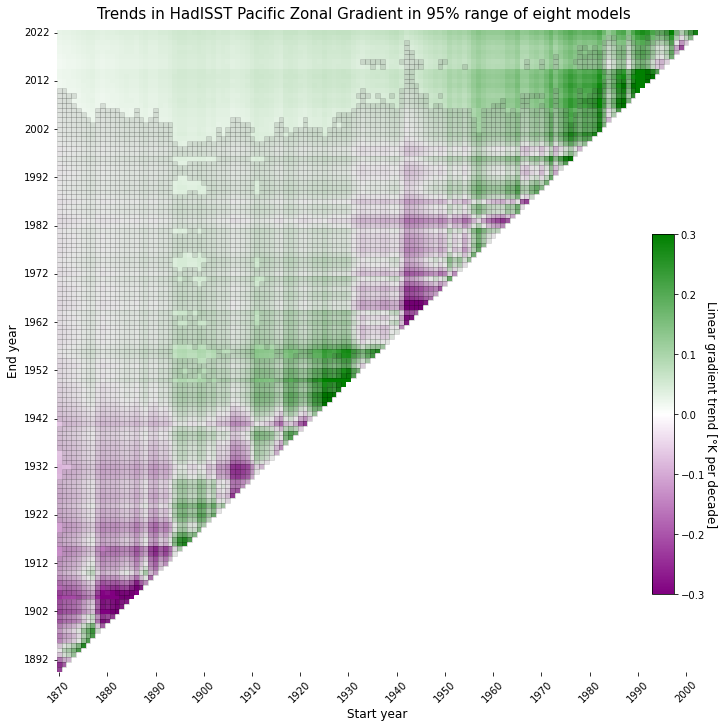

In [16]:
# plotting this
fig, ax = plt.subplots(figsize = (10,10), constrained_layout = True)
fig.suptitle('Trends in HadISST Pacific Zonal Gradient in 95% range of eight models', fontsize = 15)

vmin = -0.3
vmax = -vmin

# setting the colorbar
colors = [(0,'purple'), (0.50,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

ax.set_aspect('equal')
plot = sns.heatmap(trendsHadDf, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, center = 0, cbar = False, norm = norm)
ax.tick_params(axis = 'x', rotation = 45)
ax.tick_params(axis = 'y', rotation = 0)
ax.set_ylabel('End year', fontsize = 12)
ax.set_xlabel('Start year', fontsize = 12)

cbarAx = fig.add_axes([0.90, 0.18, 0.03, 0.5])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('Linear gradient trend [°K per decade]', rotation = 270, labelpad = 12, fontsize = 12)

# adding the stippling with a for loop
for a, row in enumerate(dfObsInRangeUni.values):
    for b, value in enumerate(row):
        if value == 1:
            plot.add_patch(plt.Rectangle((b, a), 1, 1, fill=True, color = 'black', edgecolor=None, alpha = 0.1))

# making and changing the directory
if os.path.isdir(plotsDir):
    os.chdir(plotsDir)
else:
    os.mkdir(plotsDir)
    os.chdir(plotsDir)

fileName = 'Universal_95Range_ALL.png'

for i, fig in enumerate(plt.get_fignums()):
    plt.figure(fig)
    plt.savefig(fileName)

plt.show()


## Side project: creating a 3d plot

In [17]:
dfLowestUni = DictToDf(dictLowestUni)
dfHighestUni = DictToDf(dictHighestUni)

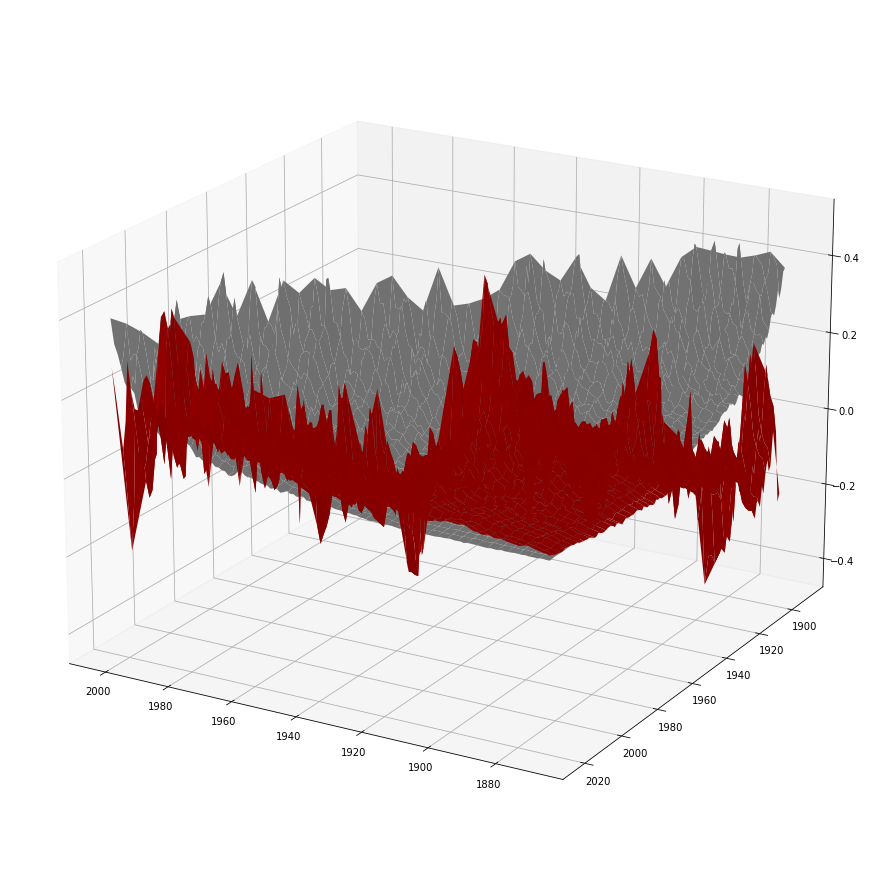

In [18]:
# first create meshgrid for x and y
startYearMesh, endYearMesh = np.meshgrid(list(trendsHadDf.columns), list(trendsHadDf.index))

fig = plt.figure(figsize = (16, 16))
ax = fig.add_subplot(projection = '3d')
ax.plot_surface(startYearMesh, endYearMesh, dfHighestUni.values, color = 'lightgray')
ax.plot_surface(startYearMesh, endYearMesh, trendsHadDf.values, color = 'red')
ax.view_init(elev=20, azim=120)

plt.show()

## 6) Calculating a new metric to separate out the models by performance

### Part 1: pattern correlation of the model mean and observations

In [204]:
# TEMP
models = ['CanESM5', 'MIROC6', 'GISS-E2-1-G', 'MPI-ESM1-2-LR', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'ACCESS-ESM1-5', 'CNRM-CM6-1']

In [205]:
# trying a new approach to weighting: difference in GHG gas forcing between two years
os.chdir(inputDir)
fileName = 'NASAGISS_Forcings.csv'

# reading in the data
forcing = pd.read_csv(fileName)

# creating a dataarray
daForcing = xr.DataArray(forcing.All, 
                        dims = 'year',
                        coords = {'year': forcing.Year})

# calculating the differences for every start and end year
dfForcingDiffs = CalcIntervalDiff(daForcing, 20).intervalDiffsDf

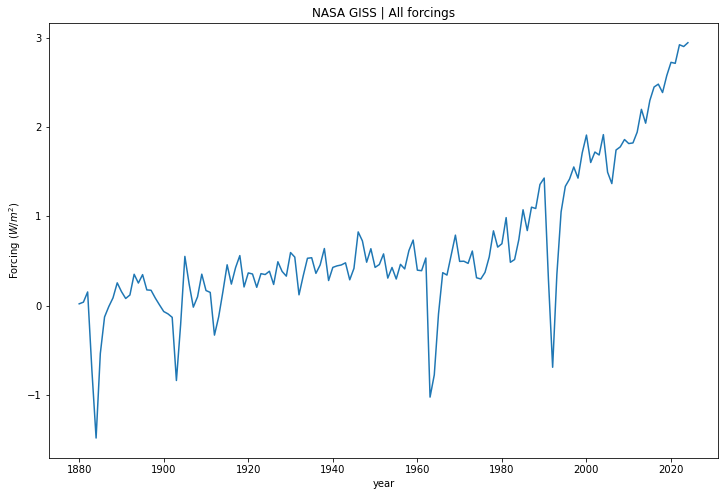

In [206]:
# plotting the forcings dataset
daForcing.sel(year = slice(1880, 2024)).plot(figsize = (12,8))
plt.title('NASA GISS | All forcings')
plt.ylabel('Forcing ($W / m^2$)')

plt.show()

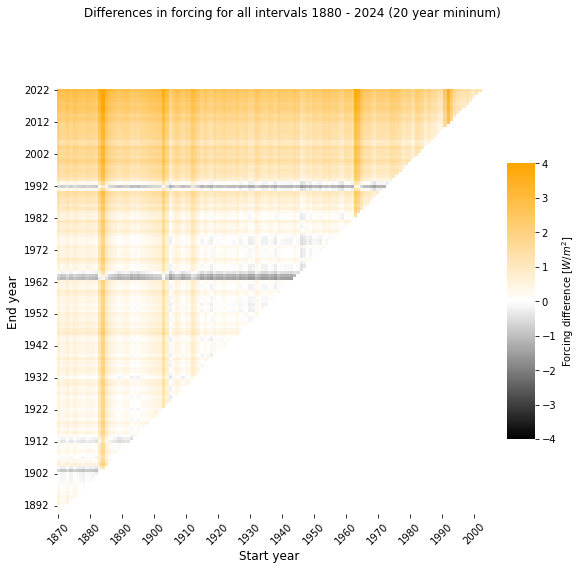

In [207]:
# creating a better colorbar for this figure
absLimit = np.max([int(abs(dfForcingDiffs.max().max())), abs(int(dfForcingDiffs.min().min()))])
vmin = -absLimit
vmax = absLimit

colors = [(0,'black'), (0.50,'white'), (1,'orange')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Orange', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

# creating figure showing the weighting (i.e., differences in values)
fig, ax = plt.subplots(figsize = (8,8), constrained_layout = True)
fig.suptitle('Differences in forcing for all intervals 1880 - 2024 (20 year mininum)')

ax.set_aspect('equal')
plot = sns.heatmap(dfForcingDiffs, cbar = True, xticklabels = 10, yticklabels = 10, cmap = cmap, norm = norm, cbar_kws={'shrink': 0.5, 'aspect': 10, 'label': 'Forcing difference [$W / m^2$]'})
ax.tick_params(axis = 'x', rotation = 45)
ax.tick_params(axis = 'y', rotation = 0)
ax.set_ylabel('End year', fontsize = 12)
ax.set_xlabel('Start year', fontsize = 12)

plt.show()

In [209]:
# --------------------
# LENGTH WEIGHTS 
# --------------------

# calculating the trend lengths for weights based on one of the time series
os.chdir(gradientsDir)
model = 'MIROC6' # just picking one to get the dates
gradientMean = CalculateMMEGradient(gradientsDir, model)
trends = Trend(gradientMean, 20, 1870, 2023).trends

# creating a dataframe of weights
# iterate through the keys of the trends and calculate the difference between them and turn that into a dataframe
dictTrendLengths = {}

for dates in trends:
    length = dates[1] - dates[0]
    
    if (length >= 20):
        dictTrendLengths[dates] = length

# creating df
dfTrendLengths = DictToDf(dictTrendLengths)

# creating weights (i.e., dividing by the whole sum) | flatten this
dfWeightsLength = pd.Series((dfTrendLengths/dfTrendLengths.sum().sum()).values.flatten())

# --------------------
# FORCING WEIGHTS 
# --------------------
dfWeightsForcing = pd.Series((dfForcingDiffs/dfForcingDiffs.sum().sum()).values.flatten())

# --------------------
# TRENDS and CORR
# --------------------

# SELECT WEIGHTING TYPE
dfWeights = dfWeightsForcing
#dfWeights = dfWeightsLength

dictCorr = {}
dictRange = {}
dictObsInRangeWeighted = {}
dictMedianStd = {}
dictStd = {}
dictMean = {}
dictLongestTrend = {}

for model in models:
    
    # -----------
    # Hadley Corr
    # -----------
    
    os.chdir(trendsDir)
    trendsFiles = os.listdir(trendsDir)
    trendsDfs = [pd.read_csv(trendsFile, index_col = 0) for trendsFile in trendsFiles if '.csv' in trendsFile and model in trendsFile]
    trendsDfMean = sum(trendsDfs) / len(trendsDfs)
    

    # create flattened arrays that are pandas dataframes (because they handle Nans well for correlation coefficients)
    dfModelTrendsFlat = pd.Series(trendsDfMean.values.flatten())
    dfHadTrendsFlat = pd.Series(trendsHadDf.values.flatten())
    
    # weighting the two input models
    dfModelTrendsWeighted = dfWeights*dfModelTrendsFlat
    dfHadTrendsWeighted = dfWeights*dfHadTrendsFlat

    # compute corr_coeff
    corr = dfModelTrendsWeighted.corr(dfHadTrendsWeighted)
    
    # save the corr
    dictCorr[model] = corr
    
    # -----------
    # Model weighted mean value
    # -----------
    mean = dfModelTrendsWeighted.mean()
    dictMean[model] = mean

    # -----------
    # Range
    # -----------

    dfRangeFlat = pd.Series(dictRanges[model].values.flatten())
    dfRangeWeighted = pd.Series(dfWeights*dfRangeFlat)
    dictRange[model] = dfRangeWeighted.mean()
    
    # -----------
    # Obs in range weighted
    # -----------
    
    dfObsInRangeFlat = pd.Series(dictObsInRangeAll[model].values.flatten())
    dfObsInRangeWeighted = pd.Series(dfWeights*dfObsInRangeFlat)
    dictObsInRangeWeighted[model] = dfObsInRangeWeighted.sum()
    
    # -----------
    # Standard deviation of models
    # -----------
    os.chdir(gradientsDir)
    gradientFiles = os.listdir(gradientsDir)
    gradientFiles = [f for f in gradientFiles if '.nc' in f and model in f]
    
    listModelStd = []
    
    for file in gradientFiles:
        # opening the file
        gradientData = xr.open_dataset(file)

        # calculating the std
        gradAnnual = gradientData.ts.groupby('time.year').mean(dim = 'time')
        std = gradAnnual.sel(year = slice(1880, 2024)).std().item()
        listModelStd.append(std)
    
    dictMedianStd[model] = np.median(listModelStd)
    
    # ---------
    # longest trend
    # ---------
    longestTrend = trendsDfMean[trendsDfMean.columns.min()].loc[trendsDfMean.index.max()]
    dictLongestTrend[model] = longestTrend

In [210]:
# now creating a master table of the values we've collected
modelSummary = pd.DataFrame(dictMembersNum.items(), columns = ['Model', 'Members'])
modelSummary = modelSummary.set_index('Model')
modelSummary['Mean'] = pd.Series(dictMean)
modelSummary['Longest_Trend'] = pd.Series(dictLongestTrend)
modelSummary['Range'] = pd.Series(dictRange)
modelSummary['SD'] = pd.Series(dictMedianStd)
modelSummary['Percent_In'] = pd.Series(dictPercentIn)*100
modelSummary['Weighted_Proportion_In'] = pd.Series(dictObsInRangeWeighted)*10000
modelSummary['CorrHad'] = pd.Series(dictCorr)
modelSummary['RangeByCorrHad'] = modelSummary['Range']*modelSummary['CorrHad']

In [211]:
modelSummary

,Members,Mean,Longest_Trend,Range,SD,Percent_In,Weighted_Proportion_In,CorrHad,RangeByCorrHad
Model,,,,,,,,,
MPI-ESM1-2-LR,31,-3.272541e-07,-0.004927,0.000017,0.661330,70.709863,2969.137260,0.381401,0.000007
CNRM-CM6-1,28,2.922969e-07,0.003094,0.000011,0.469496,61.897391,1779.190733,0.112584,0.000001
IPSL-CM6A-LR,32,7.182611e-07,0.006085,0.000006,0.469717,36.875276,939.772749,0.394728,0.000002
ACCESS-ESM1-5,30,3.926263e-07,0.006862,0.000009,0.478138,54.124281,1881.727687,-0.617232,-0.000005
CanESM5,65,3.515495e-07,0.006140,0.000006,0.377342,36.930562,1075.673986,-0.562366,-0.000003
GISS-E2-1-G,46,-2.642073e-06,-0.011412,0.000018,1.148560,72.036709,2016.398444,-0.701464,-0.000013
MIROC6,50,-4.575610e-06,-0.021748,0.000020,0.787824,76.691729,2247.089410,-0.800310,-0.000016
MIROC-ES2L,31,-6.073052e-06,-0.032565,0.000024,1.121311,76.006192,2210.369508,-0.741263,-0.000018


In [213]:
# saving out the summary table for future use
os.chdir(statsDir)
fileName = 'ModelSummaries_ForcingWeight.csv'
modelSummary.to_csv(fileName, index = True)

### SD versus points in Range

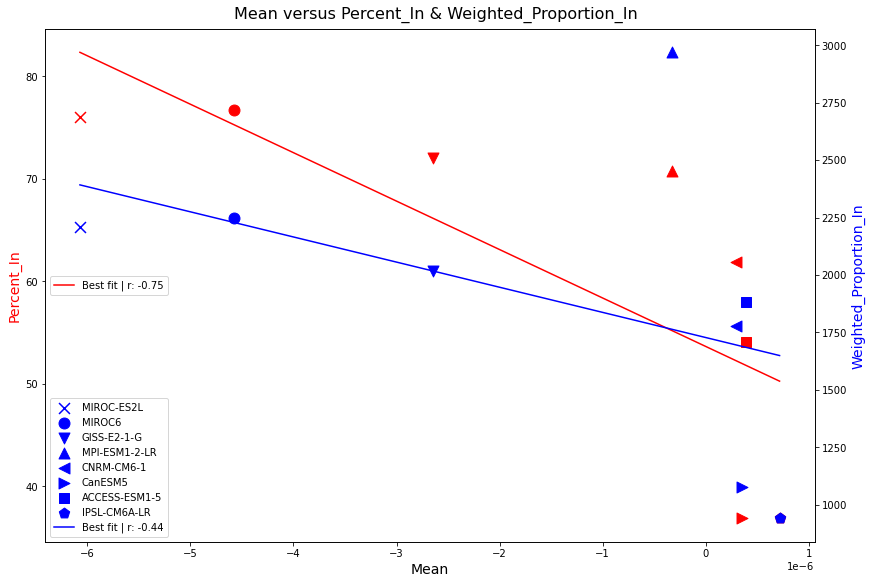

In [214]:
# calculating line of best fit and plotting that as well
xVar = 'Mean'
yVar1 = 'Percent_In'
yVar2 = 'Weighted_Proportion_In'

slope1, intercept1 = np.polyfit(modelSummary[xVar], modelSummary[yVar1], 1)
slope2, intercept2 = np.polyfit(modelSummary[xVar], modelSummary[yVar2], 1)
r1, _1 = pearsonr(modelSummary[xVar], modelSummary[yVar1])
r2, _2 = pearsonr(modelSummary[xVar], modelSummary[yVar2])

xFit = np.linspace(modelSummary[xVar].min(), modelSummary[xVar].max(), len(modelSummary.index))
yFit1 = slope1 * xFit + intercept1
yFit2 = slope2 * xFit + intercept2

# plotting
markers = ['x', 'o', 'v', '^', '<', '>', 's', 'p']
i = 0

fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)
fig.suptitle(f'{xVar} versus {yVar1} & {yVar2}', fontsize = 16)
ax.set_xlabel(f'{xVar}', fontsize = 14)
ax.set_ylabel(f'{yVar1}', fontsize = 14, color = 'red')

for index, value in modelSummary.sort_values('Mean').iterrows():
    scatter = ax.scatter(value[xVar], value[yVar1], marker = markers[i], s = 120, c = 'red')
    i += 1

ax.plot(xFit, yFit1, color = 'red', label = f'Best fit | r: {r1:.2f}')
plt.legend(loc = 'center left')

ax2 = ax.twinx()
ax2.set_ylabel(f'{yVar2}', fontsize = 14, color = 'blue')
i = 0
for index, value in modelSummary.sort_values('Mean').iterrows():
    scatter = ax2.scatter(value[xVar], value[yVar2], marker = markers[i], s = 120, label = index, c = 'blue')
    i += 1

ax2.plot(xFit, yFit2, color = 'blue', label = f'Best fit | r: {r2:.2f}')
# ax2.axvline(x = dfHadTrendsWeighted.mean(), label = 'Hadley')
plt.legend(loc = 'lower left')
plt.show()

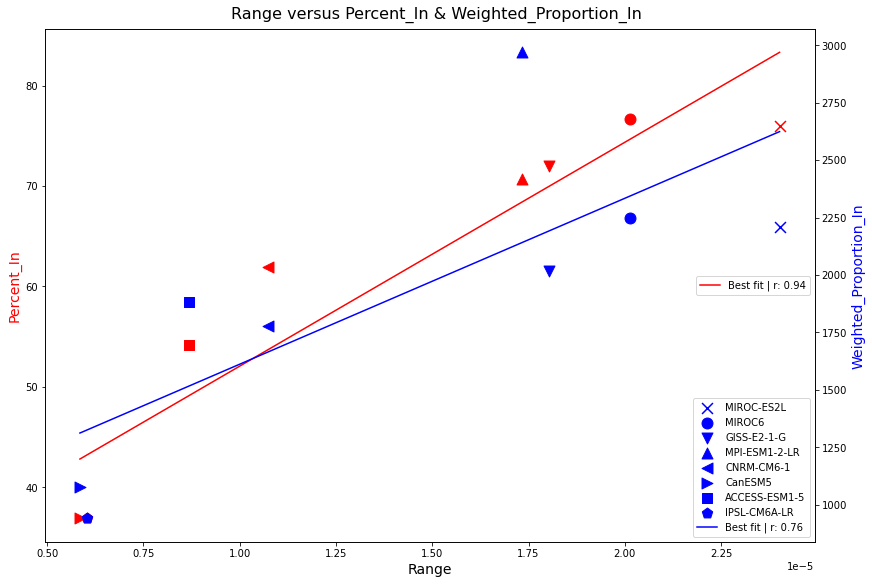

In [215]:
# calculating line of best fit and plotting that as well
xVar = 'Range'
yVar1 = 'Percent_In'
yVar2 = 'Weighted_Proportion_In'

slope1, intercept1 = np.polyfit(modelSummary[xVar], modelSummary[yVar1], 1)
slope2, intercept2 = np.polyfit(modelSummary[xVar], modelSummary[yVar2], 1)
r1, _1 = pearsonr(modelSummary[xVar], modelSummary[yVar1])
r2, _2 = pearsonr(modelSummary[xVar], modelSummary[yVar2])

xFit = np.linspace(modelSummary[xVar].min(), modelSummary[xVar].max(), len(modelSummary.index))
yFit1 = slope1 * xFit + intercept1
yFit2 = slope2 * xFit + intercept2

# plotting
markers = ['x', 'o', 'v', '^', '<', '>', 's', 'p']
i = 0

fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)
fig.suptitle(f'{xVar} versus {yVar1} & {yVar2}', fontsize = 16)
ax.set_xlabel(f'{xVar}', fontsize = 14)
ax.set_ylabel(f'{yVar1}', fontsize = 14, color = 'red')

for index, value in modelSummary.sort_values('Mean').iterrows():
    scatter = ax.scatter(value[xVar], value[yVar1], marker = markers[i], s = 120, c = 'red')
    i += 1

ax.plot(xFit, yFit1, color = 'red', label = f'Best fit | r: {r1:.2f}')
plt.legend(loc = 'center right')

ax2 = ax.twinx()
ax2.set_ylabel(f'{yVar2}', fontsize = 14, color = 'blue')
i = 0
for index, value in modelSummary.sort_values('Mean').iterrows():
    scatter = ax2.scatter(value[xVar], value[yVar2], marker = markers[i], s = 120, label = index, c = 'blue')
    i += 1

ax2.plot(xFit, yFit2, color = 'blue', label = f'Best fit | r: {r2:.2f}')
plt.legend(loc = 'lower right')
plt.show()

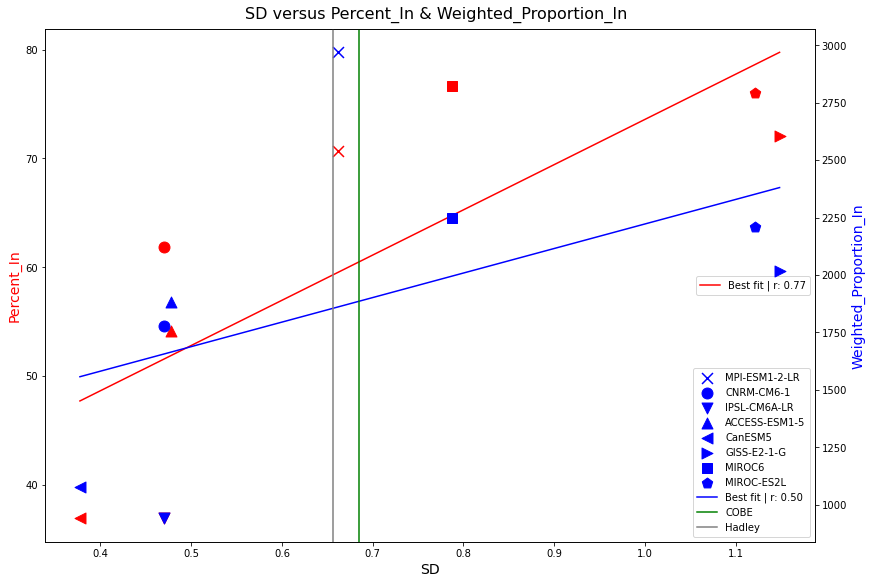

In [216]:
stdHadley = 0.6567339301109314
stdCOBE = 0.6846580505371094

# calculating line of best fit and plotting that as well
xVar = 'SD'
yVar1 = 'Percent_In'
yVar2 = 'Weighted_Proportion_In'

slope1, intercept1 = np.polyfit(modelSummary[xVar], modelSummary[yVar1], 1)
slope2, intercept2 = np.polyfit(modelSummary[xVar], modelSummary[yVar2], 1)
r1, _1 = pearsonr(modelSummary[xVar], modelSummary[yVar1])
r2, _2 = pearsonr(modelSummary[xVar], modelSummary[yVar2])

xFit = np.linspace(modelSummary[xVar].min(), modelSummary[xVar].max(), len(modelSummary.index))
yFit1 = slope1 * xFit + intercept1
yFit2 = slope2 * xFit + intercept2

# plotting
markers = ['x', 'o', 'v', '^', '<', '>', 's', 'p']
i = 0

fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)
fig.suptitle(f'{xVar} versus {yVar1} & {yVar2}', fontsize = 16)
ax.set_xlabel(f'{xVar}', fontsize = 14)
ax.set_ylabel(f'{yVar1}', fontsize = 14, color = 'red')

for index, value in modelSummary.iterrows():
    scatter = ax.scatter(value[xVar], value[yVar1], marker = markers[i], s = 120, c = 'red')
    i += 1

ax.plot(xFit, yFit1, color = 'red', label = f'Best fit | r: {r1:.2f}')
plt.legend(loc = 'center right')

ax2 = ax.twinx()
ax2.set_ylabel(f'{yVar2}', fontsize = 14, color = 'blue')
i = 0
for index, value in modelSummary.iterrows():
    scatter = ax2.scatter(value[xVar], value[yVar2], marker = markers[i], s = 120, label = index, c = 'blue')
    i += 1

ax2.plot(xFit, yFit2, color = 'blue', label = f'Best fit | r: {r2:.2f}')

ax2.axvline(x = stdCOBE, color = 'g', label = 'COBE')
ax2.axvline(x = stdHadley, color = 'gray', label = 'Hadley')

plt.legend(loc = 'lower right')
plt.show()

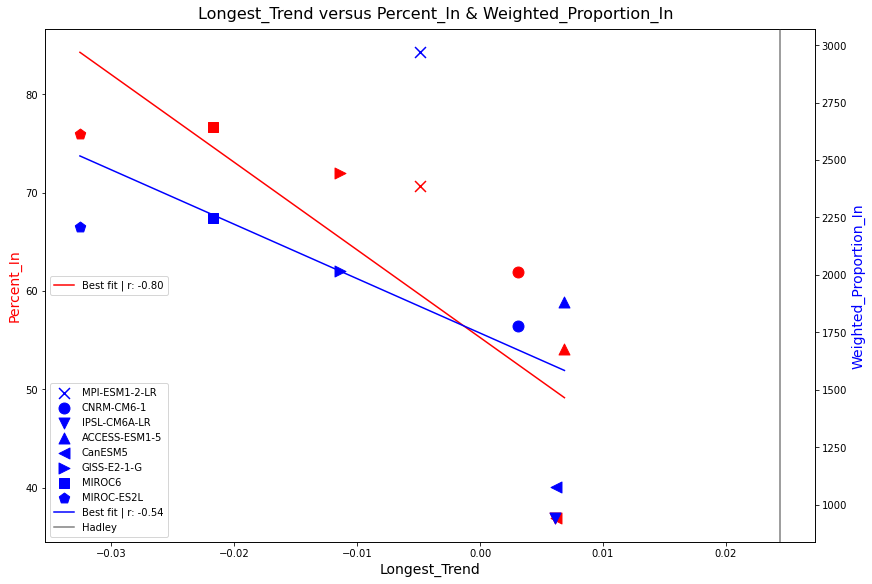

In [217]:
# calculating line of best fit and plotting that as well
xVar = 'Longest_Trend'
yVar1 = 'Percent_In'
yVar2 = 'Weighted_Proportion_In'

slope1, intercept1 = np.polyfit(modelSummary[xVar], modelSummary[yVar1], 1)
slope2, intercept2 = np.polyfit(modelSummary[xVar], modelSummary[yVar2], 1)
r1, _1 = pearsonr(modelSummary[xVar], modelSummary[yVar1])
r2, _2 = pearsonr(modelSummary[xVar], modelSummary[yVar2])

xFit = np.linspace(modelSummary[xVar].min(), modelSummary[xVar].max(), len(modelSummary.index))
yFit1 = slope1 * xFit + intercept1
yFit2 = slope2 * xFit + intercept2

# plotting
markers = ['x', 'o', 'v', '^', '<', '>', 's', 'p']
i = 0

fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)
fig.suptitle(f'{xVar} versus {yVar1} & {yVar2}', fontsize = 16)
ax.set_xlabel(f'{xVar}', fontsize = 14)
ax.set_ylabel(f'{yVar1}', fontsize = 14, color = 'red')

for index, value in modelSummary.iterrows():
    scatter = ax.scatter(value[xVar], value[yVar1], marker = markers[i], s = 120, c = 'red')
    i += 1

ax.plot(xFit, yFit1, color = 'red', label = f'Best fit | r: {r1:.2f}')
plt.legend(loc = 'center left')

ax2 = ax.twinx()
ax2.set_ylabel(f'{yVar2}', fontsize = 14, color = 'blue')
i = 0
for index, value in modelSummary.iterrows():
    scatter = ax2.scatter(value[xVar], value[yVar2], marker = markers[i], s = 120, label = index, c = 'blue')
    i += 1

ax2.plot(xFit, yFit2, color = 'blue', label = f'Best fit | r: {r2:.2f}')

ax2.axvline(x = trendsHadDf[trendsHadDf.columns.min()].loc[trendsHadDf.index.max()], color = 'gray', label = 'Hadley')

plt.legend(loc = 'lower left')
plt.show()

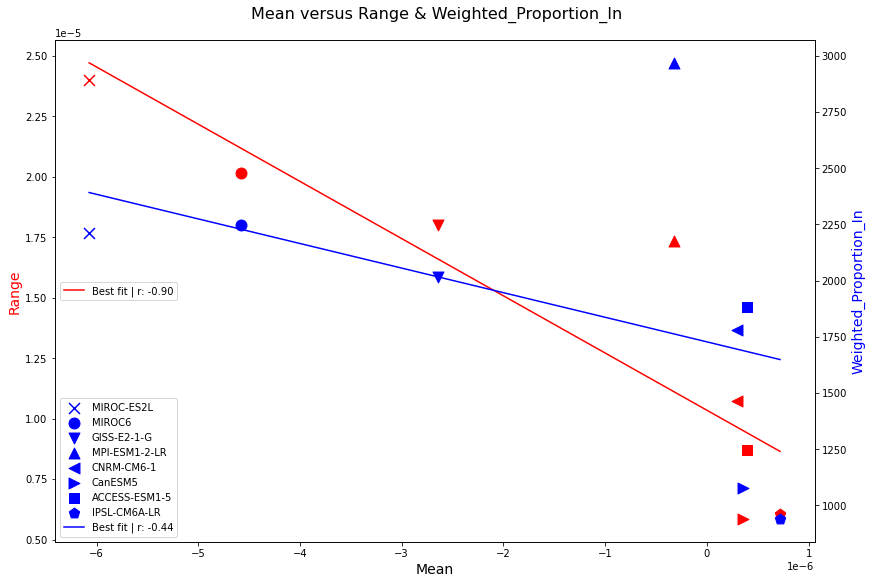

In [218]:
# calculating line of best fit and plotting that as well
xVar = 'Mean'
yVar1 = 'Range'
yVar2 = 'Weighted_Proportion_In'

slope1, intercept1 = np.polyfit(modelSummary[xVar], modelSummary[yVar1], 1)
slope2, intercept2 = np.polyfit(modelSummary[xVar], modelSummary[yVar2], 1)
r1, _1 = pearsonr(modelSummary[xVar], modelSummary[yVar1])
r2, _2 = pearsonr(modelSummary[xVar], modelSummary[yVar2])

xFit = np.linspace(modelSummary[xVar].min(), modelSummary[xVar].max(), len(modelSummary.index))
yFit1 = slope1 * xFit + intercept1
yFit2 = slope2 * xFit + intercept2

# plotting
markers = ['x', 'o', 'v', '^', '<', '>', 's', 'p']
i = 0

fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)
fig.suptitle(f'{xVar} versus {yVar1} & {yVar2}', fontsize = 16)
ax.set_xlabel(f'{xVar}', fontsize = 14)
ax.set_ylabel(f'{yVar1}', fontsize = 14, color = 'red')

for index, value in modelSummary.sort_values('Mean').iterrows():
    scatter = ax.scatter(value[xVar], value[yVar1], marker = markers[i], s = 120, c = 'red')
    i += 1

ax.plot(xFit, yFit1, color = 'red', label = f'Best fit | r: {r1:.2f}')
plt.legend(loc = 'center left')

ax2 = ax.twinx()
ax2.set_ylabel(f'{yVar2}', fontsize = 14, color = 'blue')
i = 0
for index, value in modelSummary.sort_values('Mean').iterrows():
    scatter = ax2.scatter(value[xVar], value[yVar2], marker = markers[i], s = 120, label = index, c = 'blue')
    i += 1

ax2.plot(xFit, yFit2, color = 'blue', label = f'Best fit | r: {r2:.2f}')

plt.legend(loc = 'lower left')
plt.show()

In [203]:
modelSummary

,Members,Range,Percent_In,Weighted_Proportion_In,CorrHad,RangeByCorrHad
Model,,,,,,
CanESM5,65,0.000006,37.436876,0.359723,-0.355479,-2.011864e-06
MIROC6,50,0.000020,77.712939,0.726445,-0.558057,-1.115531e-05
GISS-E2-1-G,46,0.000018,73.100662,0.665123,-0.551295,-9.924631e-06
MPI-ESM1-2-LR,31,0.000016,71.462238,0.741397,-0.024156,-3.947428e-07
IPSL-CM6A-LR,32,0.000006,37.335877,0.352097,-0.146428,-8.796635e-07
MIROC-ES2L,31,0.000025,77.656829,0.739625,-0.568294,-1.413736e-05
ACCESS-ESM1-5,30,0.000009,54.988217,0.555950,-0.294088,-2.544186e-06
CNRM-CM6-1,28,0.000011,62.810010,0.583228,-0.129370,-1.399439e-06


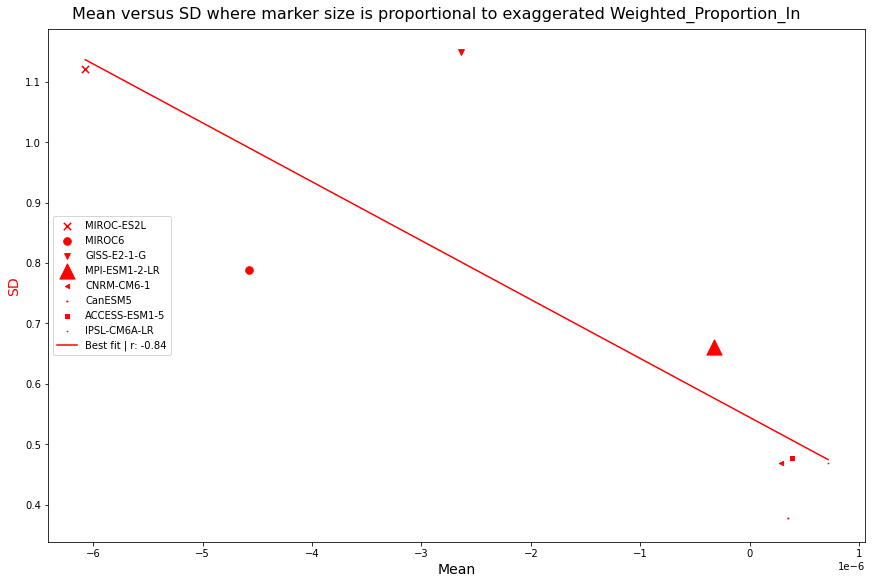

In [225]:
# calculating line of best fit and plotting that as well
xVar = 'Mean'
yVar1 = 'SD'
sizeVar = 'Weighted_Proportion_In'

slope1, intercept1 = np.polyfit(modelSummary[xVar], modelSummary[yVar1], 1)
r1, _1 = pearsonr(modelSummary[xVar], modelSummary[yVar1])

xFit = np.linspace(modelSummary[xVar].min(), modelSummary[xVar].max(), len(modelSummary.index))
yFit1 = slope1 * xFit + intercept1

# plotting
markers = ['x', 'o', 'v', '^', '<', '>', 's', 'p']
i = 0

fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)
fig.suptitle(f'{xVar} versus {yVar1} where marker size is proportional to exaggerated {sizeVar}', fontsize = 16)
ax.set_xlabel(f'{xVar}', fontsize = 14)
ax.set_ylabel(f'{yVar1}', fontsize = 14, color = 'red')

for index, value in modelSummary.sort_values('Mean').iterrows():
    scatter = ax.scatter(value[xVar], value[yVar1], marker = markers[i], s = (value[sizeVar]/1000)**5, c = 'red', label = index)
    i += 1

ax.plot(xFit, yFit1, color = 'red', label = f'Best fit | r: {r1:.2f}')
#ax.axvline(x = dfHadTrendsWeighted.mean(), label = 'Hadley')
plt.legend(loc = 'center left')

plt.show()

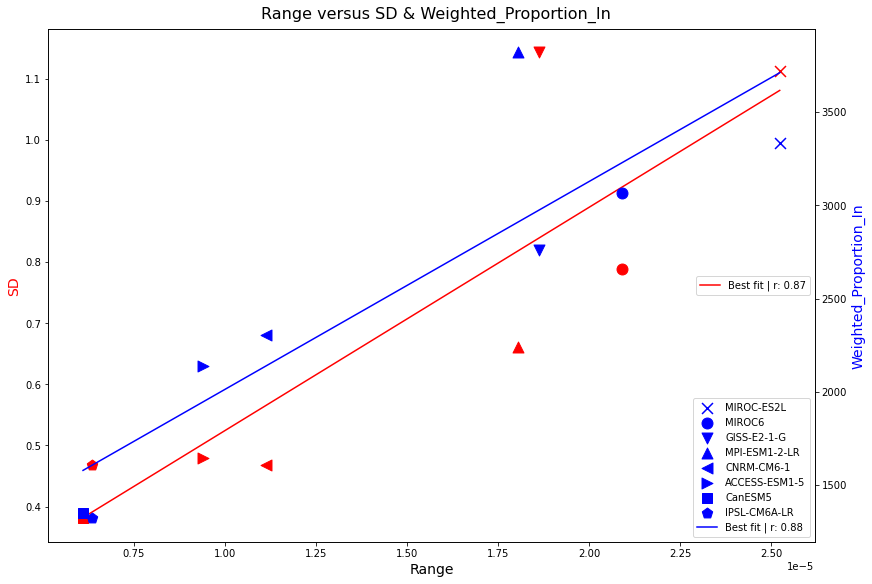

In [115]:
# calculating line of best fit and plotting that as well
xVar = 'Range'
yVar1 = 'SD'
yVar2 = 'Weighted_Proportion_In'

slope1, intercept1 = np.polyfit(modelSummary[xVar], modelSummary[yVar1], 1)
slope2, intercept2 = np.polyfit(modelSummary[xVar], modelSummary[yVar2], 1)
r1, _1 = pearsonr(modelSummary[xVar], modelSummary[yVar1])
r2, _2 = pearsonr(modelSummary[xVar], modelSummary[yVar2])

xFit = np.linspace(modelSummary[xVar].min(), modelSummary[xVar].max(), len(modelSummary.index))
yFit1 = slope1 * xFit + intercept1
yFit2 = slope2 * xFit + intercept2

# plotting
markers = ['x', 'o', 'v', '^', '<', '>', 's', 'p']
i = 0

fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)
fig.suptitle(f'{xVar} versus {yVar1} & {yVar2}', fontsize = 16)
ax.set_xlabel(f'{xVar}', fontsize = 14)
ax.set_ylabel(f'{yVar1}', fontsize = 14, color = 'red')

for index, value in modelSummary.sort_values('Mean').iterrows():
    scatter = ax.scatter(value[xVar], value[yVar1], marker = markers[i], s = 120, c = 'red')
    i += 1

ax.plot(xFit, yFit1, color = 'red', label = f'Best fit | r: {r1:.2f}')
plt.legend(loc = 'center right')

ax2 = ax.twinx()
ax2.set_ylabel(f'{yVar2}', fontsize = 14, color = 'blue')
i = 0
for index, value in modelSummary.sort_values('Mean').iterrows():
    scatter = ax2.scatter(value[xVar], value[yVar2], marker = markers[i], s = 120, label = index, c = 'blue')
    i += 1

ax2.plot(xFit, yFit2, color = 'blue', label = f'Best fit | r: {r2:.2f}')
plt.legend(loc = 'lower right')
plt.show()

## Quick check: Scaling range by ratio of SD to Hadley SD

In [155]:
# first thing is to get a dictionary of trends for a model

model = 'GISS-E2-1-G' # temporary

os.chdir(trendsDir)
modelTrends = TrendsDictFromFiles(trendsDir, model)

# calculate the ratio of Hadley to model standard deviation
sdRatio = stdHadley / modelSummary.loc[model]['SD']

# create an empty dictionary for the scaled trends
trendsScaled = {}

# now scale all of the trends relative to the **mean** trend
for dates, trends in modelTrends.items():
    trendsScaled[dates] = ScaleTrends(trends, sdRatio)

In [156]:
# plotting the results

# first calculating the upper and lower dictionary values
dictLowerScaled, dictUpperScaled = CalculateTrendPercentile(trendsScaled, 2.5, 97.5)
dfRangeScaled = CalculateModelRange(dictLowerScaled, dictUpperScaled)

# doing the same for the unscaled values
dictLower, dictUpper = CalculateTrendPercentile(modelTrends, 2.5, 97.5)
dfRange = CalculateModelRange(dictLower, dictUpper)

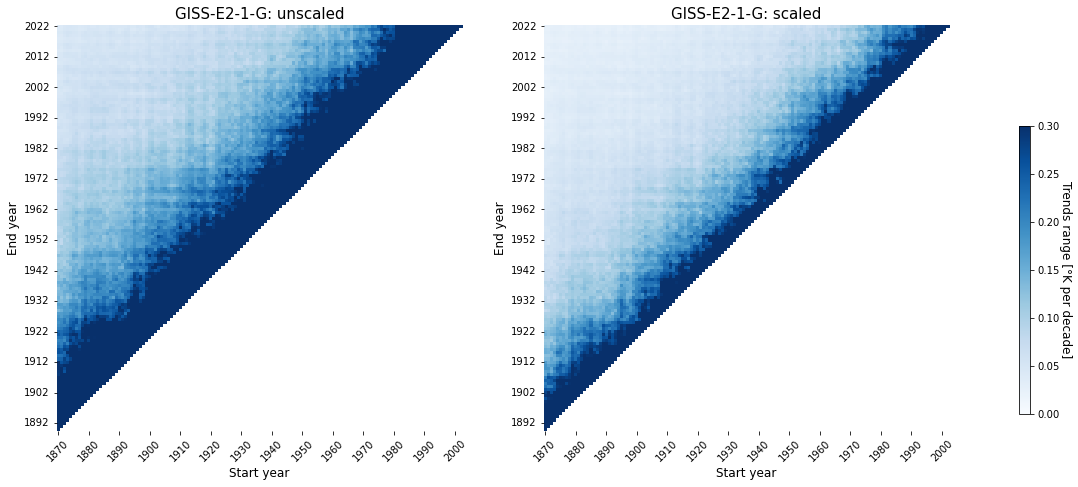

In [157]:
vmin = 0
vmax = 0.3 # Note that these values were selected after running it once and looking at the max and min of the whole spread; have to be changed manually

# setting the colorbar
cmap = 'Blues'
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,8))
ax[0].set_aspect('equal')    
ax[0].set_title(f'{model}: unscaled', fontsize = 15)

ax[1].set_aspect('equal')
ax[1].set_title(f'{model}: scaled', fontsize = 15)

plot = sns.heatmap(dfRange, cmap = cmap, ax = ax[0], vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
ax[0].tick_params(axis = 'x', rotation = 45)
ax[0].tick_params(axis = 'y', rotation = 0)
ax[0].set_ylabel('End year', fontsize = 12)
ax[0].set_xlabel('Start year', fontsize = 12)

plot = sns.heatmap(dfRangeScaled, cmap = cmap, ax = ax[1], vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
ax[1].tick_params(axis = 'x', rotation = 45)
ax[1].tick_params(axis = 'y', rotation = 0)
ax[1].set_ylabel('End year', fontsize = 12)
ax[1].set_xlabel('Start year', fontsize = 12)

cbarAx = fig.add_axes([0.96, 0.18, 0.01, 0.5])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('Trends range [°K per decade]', rotation = 270, labelpad = 12, fontsize = 12)

CanESM5 is done and dusted
MIROC6 is done and dusted
GISS-E2-1-G is done and dusted
MPI-ESM1-2-LR is done and dusted
IPSL-CM6A-LR is done and dusted
MIROC-ES2L is done and dusted
ACCESS-ESM1-5 is done and dusted
CNRM-CM6-1 is done and dusted


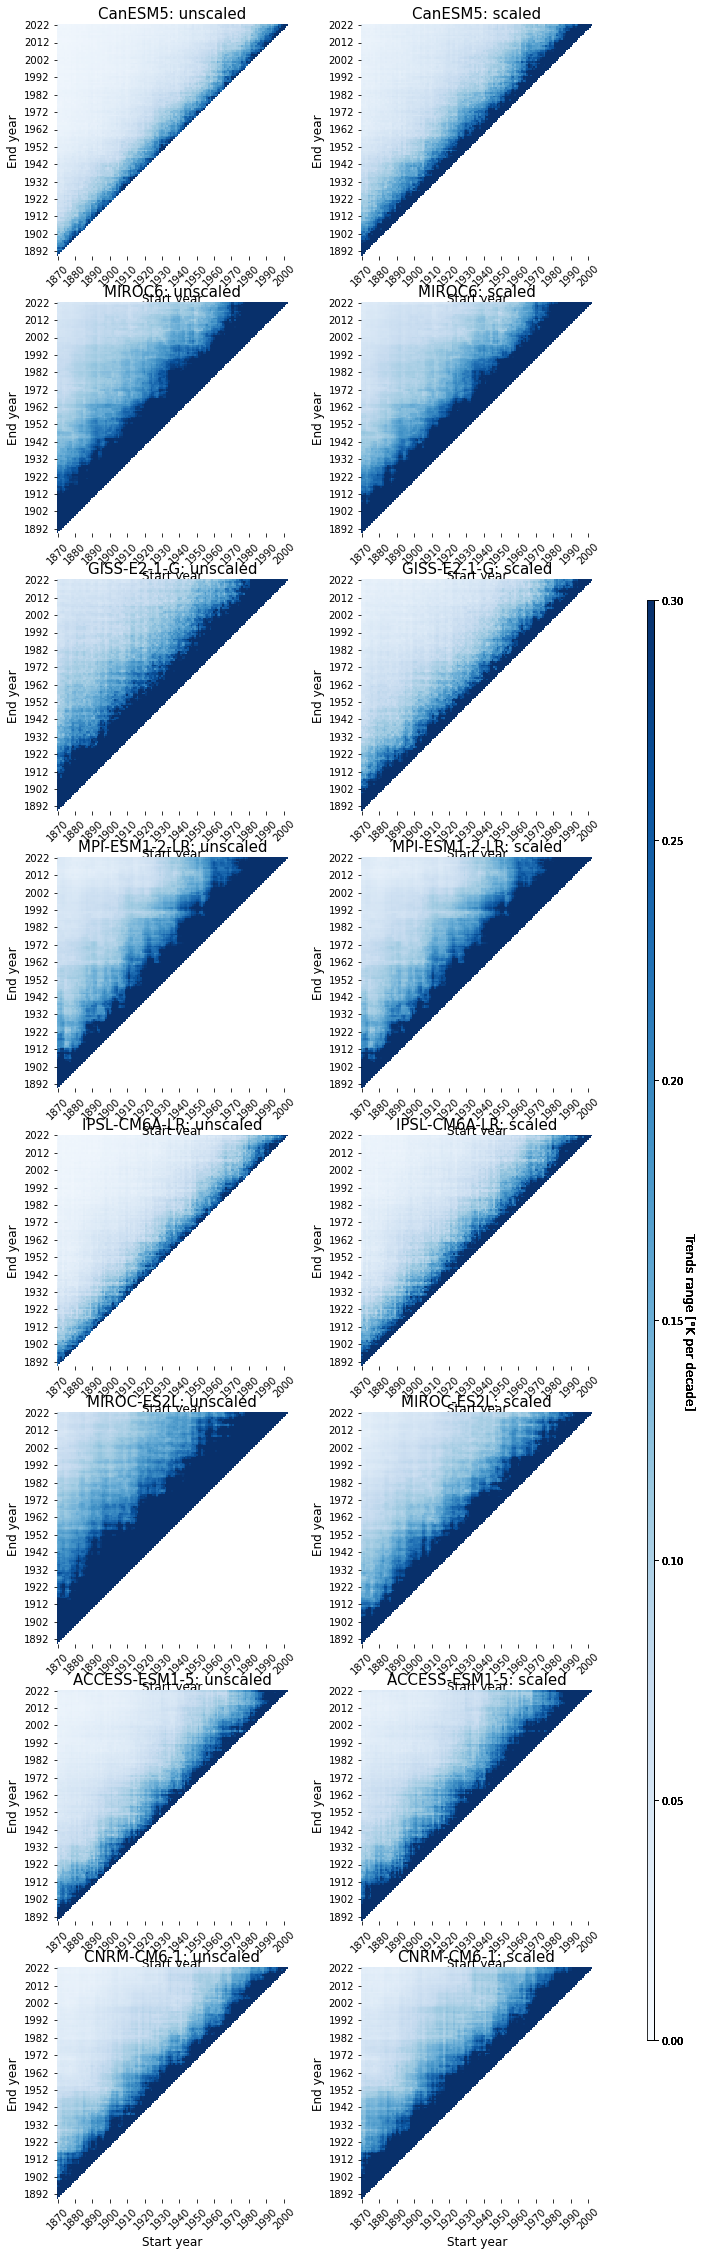

In [165]:
# combining into one for loop

vmin = 0
vmax = 0.3 # Note that these values were selected after running it once and looking at the max and min of the whole spread; have to be changed manually

# setting the colorbar
cmap = 'Blues'
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

plotDims = (5,5)
figWidth = plotDims[0]
figHeight = plotDims[1]

nRows = len(models)
nCols = 2

fig, ax = plt.subplots(nrows = nRows, ncols = nCols, figsize = (figWidth*nCols, figHeight*nRows))
axFlat = ax.flatten()

for i, model in enumerate(models):

    # first thing is to get a dictionary of trends for a model
    os.chdir(trendsDir)
    modelTrends = TrendsDictFromFiles(trendsDir, model)

    # calculate the ratio of Hadley to model standard deviation
    sdRatio = stdHadley / modelSummary.loc[model]['SD']

    # create an empty dictionary for the scaled trends
    trendsScaled = {}

    # now scale all of the trends relative to the **mean** trend
    for dates, trends in modelTrends.items():
        trendsScaled[dates] = ScaleTrends(trends, sdRatio)
    
    # --------------------
    # plotting the results
    # --------------------

    # first calculating the upper and lower dictionary values
    dictLowerScaled, dictUpperScaled = CalculateTrendPercentile(trendsScaled, 2.5, 97.5)
    dfRangeScaled = CalculateModelRange(dictLowerScaled, dictUpperScaled)

    # doing the same for the unscaled values
    dictLower, dictUpper = CalculateTrendPercentile(modelTrends, 2.5, 97.5)
    dfRange = CalculateModelRange(dictLower, dictUpper)
    
    axFlat[2*i].set_aspect('equal')    
    axFlat[2*i].set_title(f'{model}: unscaled', fontsize = 15)

    axFlat[2*i+1].set_aspect('equal')
    axFlat[2*i+1].set_title(f'{model}: scaled', fontsize = 15)

    plot = sns.heatmap(dfRange, cmap = cmap, ax = axFlat[2*i], vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    axFlat[2*i].tick_params(axis = 'x', rotation = 45)
    axFlat[2*i].tick_params(axis = 'y', rotation = 0)
    axFlat[2*i].set_ylabel('End year', fontsize = 12)
    axFlat[2*i].set_xlabel('Start year', fontsize = 12)

    plot = sns.heatmap(dfRangeScaled, cmap = cmap, ax = axFlat[2*i+1], vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    axFlat[2*i+1].tick_params(axis = 'x', rotation = 45)
    axFlat[2*i+1].tick_params(axis = 'y', rotation = 0)
    axFlat[2*i+1].set_ylabel('End year', fontsize = 12)
    axFlat[2*i+1].set_xlabel('Start year', fontsize = 12)

    cbarAx = fig.add_axes([0.96, 0.18, 0.01, 0.5])
    colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Trends range [°K per decade]', rotation = 270, labelpad = 12, fontsize = 12)
    
    print(f'{model} is done and dusted')